In [ ]:
 !pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 5.1 MB/s eta 0:00:00


In [ ]:
import tensorflow_datasets as tfds
 
dataset, info = tfds.load("oxford_iiit_pet:3.*.*", with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteIVDKRZ/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteIVDKRZ/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
import tensorflow as tf
from tensorflow.keras import backend

image_size = 512
mean = tf.constant([0.485, 0.456, 0.406])
std = tf.constant([0.229, 0.224, 0.225])

def normalize(input_image, input_mask):
  input_image = tf.image.convert_image_dtype(input_image, tf.float32)
  input_image = (input_image - mean) / tf.maximum(std, backend.epsilon())
  input_mask = tf.where(tf.equal(input_mask, 2), tf.zeros_like(input_mask), input_mask)
  input_mask = tf.where(tf.equal(input_mask, 3), tf.zeros_like(input_mask), input_mask)
  return input_image, input_mask

In [ ]:
def load_image(datapoint):
    input_image = tf.image.resize(datapoint["image"], (image_size, image_size))
    input_mask = tf.image.resize(
        datapoint["segmentation_mask"],
        (image_size, image_size),
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR,    )

    input_image, input_mask = normalize(input_image, input_mask)
    input_image = tf.transpose(input_image, (2, 0, 1))
    return {"pixel_values": input_image, "labels": tf.squeeze(input_mask)}

In [ ]:
auto = tf.data.AUTOTUNE
batch_size = 5

training = (dataset["train"].cache().shuffle(batch_size * 10).map(load_image, num_parallel_calls=auto).batch(batch_size).prefetch(auto))
testing = (dataset["test"].map(load_image, num_parallel_calls=auto).batch(batch_size).prefetch(auto))

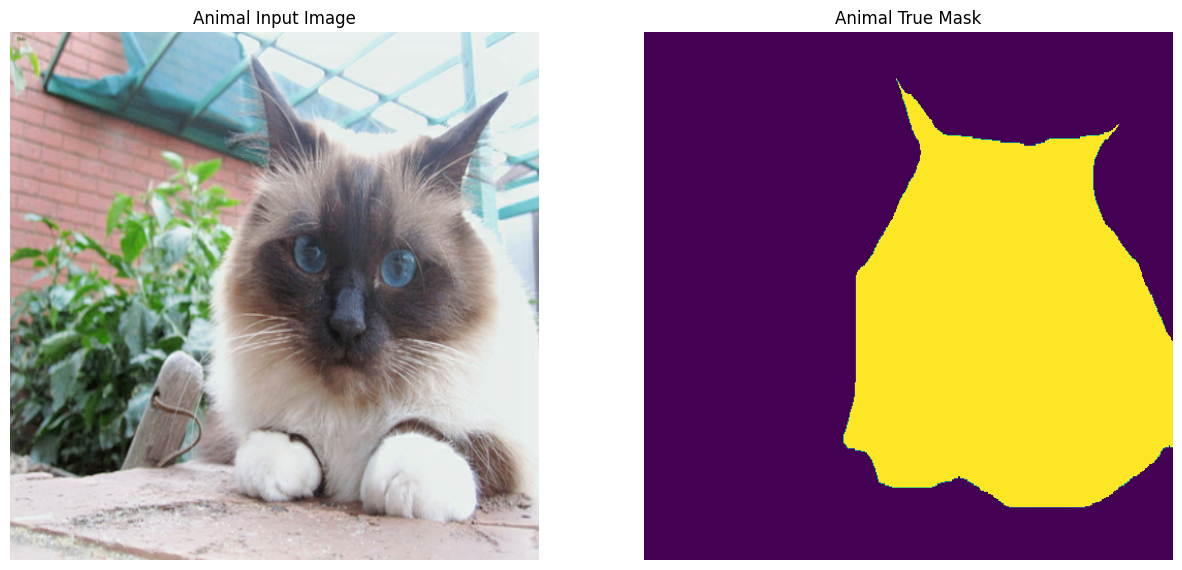

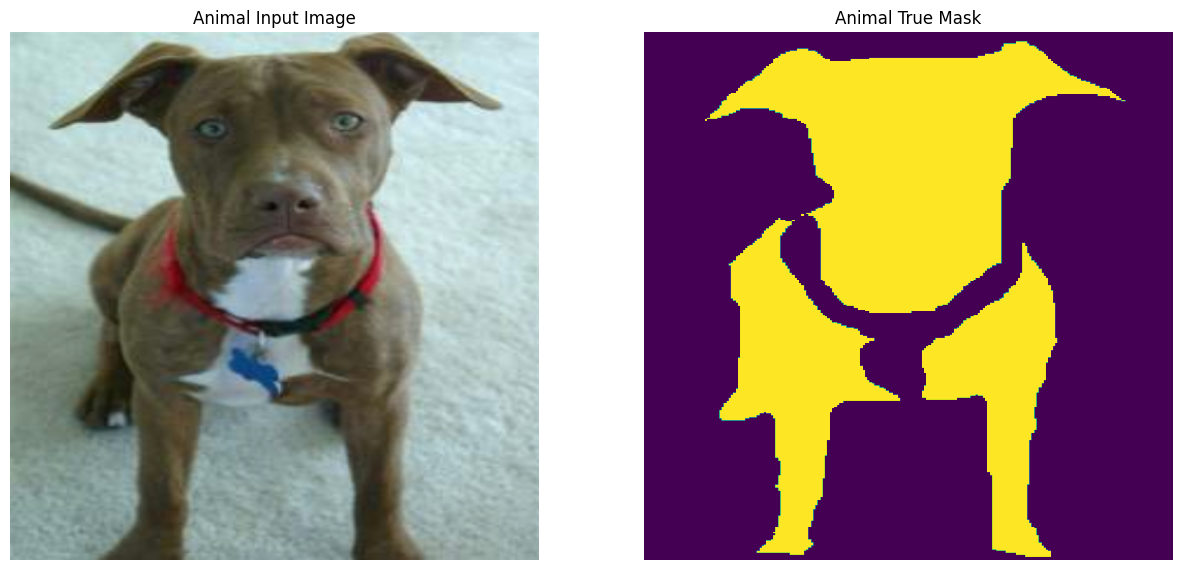

In [ ]:
import matplotlib.pyplot as plt


def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Animal Input Image", "Animal True Mask", "Animal Mask Prediction"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()


for samples in training.take(2):
    sample_image, sample_mask = samples["pixel_values"][0], samples["labels"][0]
    sample_image = tf.transpose(sample_image, (1, 2, 0))
    sample_mask = tf.expand_dims(sample_mask, -1)
    display([sample_image, sample_mask])

In [ ]:
from transformers import TFSegformerForSemanticSegmentation

model_checkpoint = "nvidia/mit-b0"
Label = {0: "outer", 1: "inner"}
label2id = {label: id for id, label in Label.items()}
num_labels = len(Label)
My_Model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=Label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some layers from the model checkpoint at nvidia/mit-b0 were not used when initializing TFSegformerForSemanticSegmentation: ['classifier']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
lr = 0.00006
My_Model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr))

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
from IPython.display import clear_output


def create_mask(prd_mask):
    prd_mask = tf.math.argmax(prd_mask, axis=1)
    prd_mask = tf.expand_dims(prd_mask, -1)
    return prd_mask[0]


def show_predictions(dataset=None, num=1):
    if dataset:
        for sample in dataset.take(num):
            images, masks = sample["pixel_values"], sample["labels"]
            masks = tf.expand_dims(masks, -1)
            pred_masks = My_Model.predict(images).logits
            images = tf.transpose(images, (0, 2, 3, 1))
            display([images[0], masks[0], create_mask(pred_masks)])
    else:
        display(
            [
                sample_image,
                sample_mask,
                create_mask(My_Model.predict(tf.expand_dims(sample_image, 0))),
            ]
        )


In [ ]:
epochs = 4

history = My_Model.fit(training, validation_data=testing, epochs=epochs)


Epoch 1/4
736/736 [==============================] - 465s 539ms/step - loss: 0.1801 - val_loss: 0.1208
Epoch 2/4
736/736 [==============================] - 343s 466ms/step - loss: 0.1172 - val_loss: 0.1064
Epoch 3/4
736/736 [==============================] - 392s 532ms/step - loss: 0.1009 - val_loss: 0.1072
Epoch 4/4
736/736 [==============================] - 392s 533ms/step - loss: 0.0912 - val_loss: 0.1039


1/1 [==============================] - 0s 230ms/step


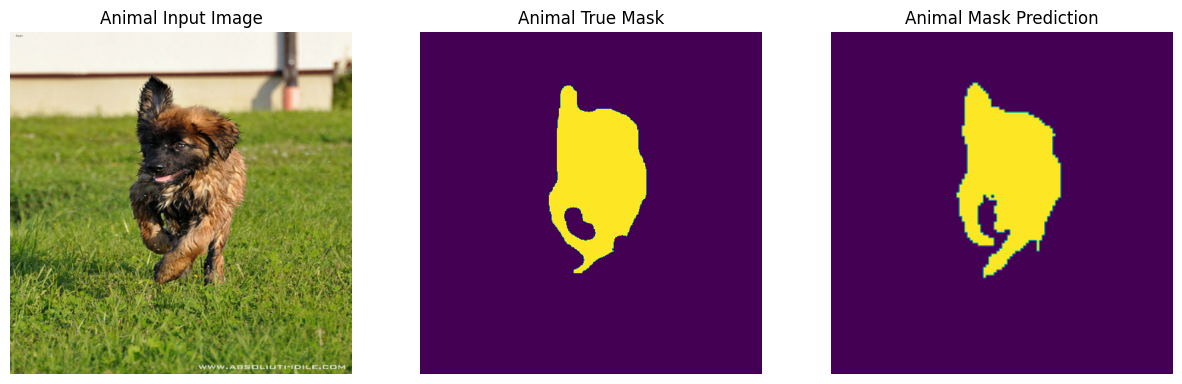

1/1 [==============================] - 0s 207ms/step


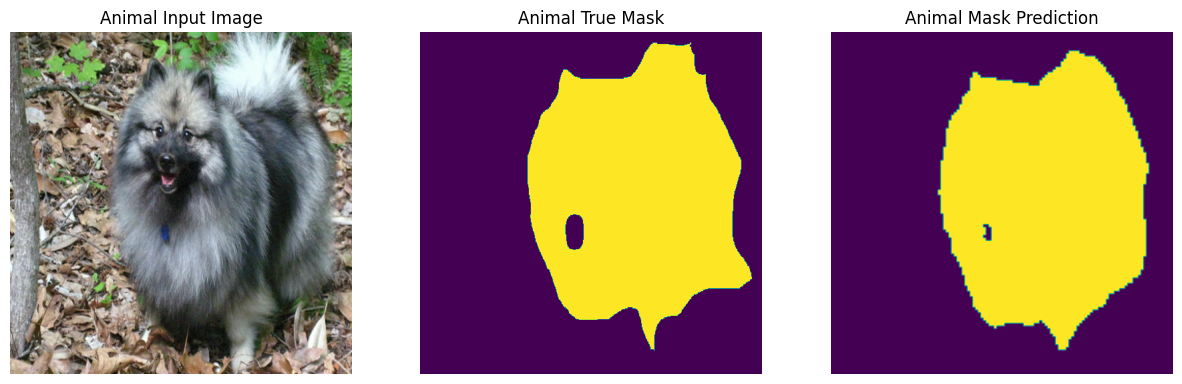

1/1 [==============================] - 0s 203ms/step


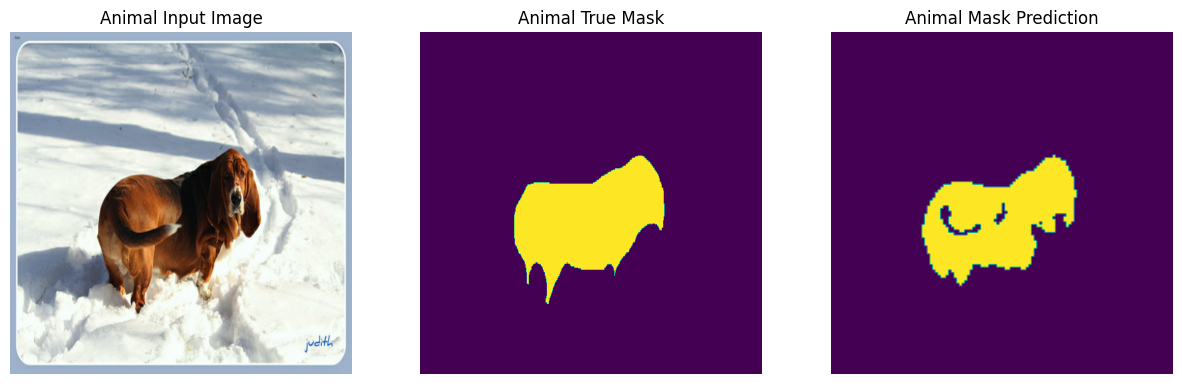

In [ ]:
show_predictions(testing, 3)